# Neural network for MNIST fashion dataset
Uses only basic libraries
- Numpy for linear algebra
- Pandas for storing results
- Matplotlib to plot images

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import importlib
# from layers import LayerDense, ActivationReLU, ActivationTanh, ActivationSoftmax, CrossEntropyLoss, GradientDescent, one_hot_encode
import layers as ly


### Data formating
Need each datapoint ie. each image as a vector. Hence all data points are column vectors of 784 dimension

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = np.reshape(x_train, (-1, 784)).T / 255 # features x samples
x_test = np.reshape(x_test, (-1, 784)).T / 255 # features x samples

y_train = ly.one_hot_encode(y_train) # one-hot encode labels x samples
y_test = ly.one_hot_encode(y_test) # one-hot encode labels x samples

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(x_train.dtype)


(784, 60000) (10, 60000) (784, 10000) (10, 10000)
float64


(28, 28, 60000)


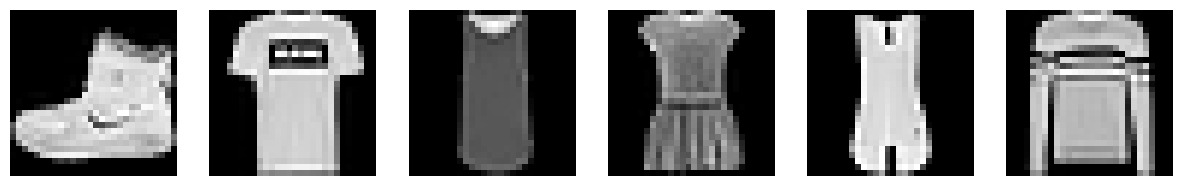

In [3]:
fig, ax = plt.subplots(1, 6, figsize=(15, 6))
plt.set_cmap('gray')
print(np.reshape(x_train, (28, 28, -1)).shape)
for i in range(6):
    ax[i].imshow(np.reshape(x_train, (28, 28, -1))[:, :, i])
    ax[i].axis('off')

In [10]:
importlib.reload(ly) 

network = [
    ly.LayerDense(784, 128),
    ly.ActivationReLU(),
    ly.Dropout(rate=0.2),          # Dropout after first hidden layer
    ly.LayerDense(128, 64),
    ly.ActivationReLU(),
    ly.Dropout(rate=0.4),          # Dropout after second hidden layer
    ly.LayerDense(64, 32),
    ly.ActivationReLU(),
    ly.Dropout(rate=0.2),          # Dropout after third hidden layer
    ly.LayerDense(32, 10),
    ly.ActivationSoftmaxLossCrossEntropy()
]

epochs = 100
learning_rate = 0.01
batch_size = 128
total_samples = x_train.shape[1]

optimizer = ly.AdamOptimizer(learning_rate=0.001)

for epoch in range(epochs):
    indices = np.random.permutation(total_samples)
    x_shuffled = x_train[:, indices]
    y_shuffled = y_train[:, indices]

    epoch_loss = 0
    correct = 0

    for start in range(0, total_samples, batch_size):
        end = start + batch_size
        x_batch = x_shuffled[:, start:end]
        y_batch = y_shuffled[:, start:end]

        # Forward pass
        inputs = x_batch
        for layer in network:
            # Dropout is only active during training
            if isinstance(layer, ly.Dropout):
                inputs = layer.forward(inputs, training=True)
            else:
                inputs = layer.forward(inputs)
        predictions = inputs

        # Loss
        loss = network[-1].loss(y_batch)
        epoch_loss += loss * x_batch.shape[1]  # Weighted sum

        # Accuracy
        y_pred = np.argmax(predictions, axis=0)
        y_label = np.argmax(y_batch, axis=0)
        correct += np.sum(y_pred == y_label)

        # Backward pass
        d_loss = network[-1].backward(y_batch)
        for layer in reversed(network[:-1]):
            d_loss = layer.backward(d_loss)

        # Update weights
        for layer in network:
            if isinstance(layer, ly.LayerDense):
                dw, db = layer.gradient()
                optimizer.update(layer)

    avg_loss = epoch_loss / total_samples
    accuracy = correct / total_samples
    if epoch%5 == 0:
        print(f'Epoch {epoch}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch 0, Loss: 0.7928, Accuracy: 0.7156
Epoch 5, Loss: 0.3837, Accuracy: 0.8670
Epoch 10, Loss: 0.3392, Accuracy: 0.8810
Epoch 15, Loss: 0.3086, Accuracy: 0.8909
Epoch 20, Loss: 0.2944, Accuracy: 0.8953
Epoch 25, Loss: 0.2794, Accuracy: 0.8990
Epoch 30, Loss: 0.2640, Accuracy: 0.9067
Epoch 35, Loss: 0.2586, Accuracy: 0.9085
Epoch 40, Loss: 0.2516, Accuracy: 0.9100
Epoch 45, Loss: 0.2410, Accuracy: 0.9128
Epoch 50, Loss: 0.2373, Accuracy: 0.9146
Epoch 55, Loss: 0.2344, Accuracy: 0.9150
Epoch 60, Loss: 0.2260, Accuracy: 0.9201
Epoch 65, Loss: 0.2248, Accuracy: 0.9182
Epoch 70, Loss: 0.2162, Accuracy: 0.9224
Epoch 75, Loss: 0.2156, Accuracy: 0.9226
Epoch 80, Loss: 0.2129, Accuracy: 0.9245
Epoch 85, Loss: 0.2088, Accuracy: 0.9259
Epoch 90, Loss: 0.2031, Accuracy: 0.9265
Epoch 95, Loss: 0.2020, Accuracy: 0.9282


In [20]:
# test
inputs = x_test
for layer in network:
    inputs = layer.forward(inputs)
predictions = inputs
y_pred = np.argmax(predictions, axis=0)
y_label = np.argmax(y_test, axis=0)
correct = np.sum(y_pred == y_label)
accuracy = correct / y_test.shape[1]
print(f'Test Accuracy: {accuracy:.4f}')


Test Accuracy: 0.8757
